# Seq2Seq
Unlike the previous two notebooks, the material in this one (unless you've worked closely with NLP or the like) will likely be new to you. However, the main novelty can be summarized as follows: using RNNs in an encoder/decoder architecture.

Encoder/decoders come up *all* the time in deep learning, so it's useful to become familiar with the concept now: there are differences in implementation details of what the encoder and decoder sides looks like, but fundamentally this design pattern is quite common. Let's load in the data.

The data loading is more involved this time around, but we'll ignore the details for now. We will ultimately need to see how such work would translate to the AlphaFold case, but let's focus on the model for now:

In [100]:
import re
import os
import random
import pandas as pd
import numpy as np
import urllib.request
import unicodedata
import zipfile
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F

torch.manual_seed(0)

In [23]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

if not os.path.exists("data.zip"):
    url = "https://download.pytorch.org/tutorial/data.zip"
    urllib.request.urlretrieve(url, "data.zip")

with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall(".")
    
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

tensor_pairs = [tensorsFromPair(pair) for pair in pairs]

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['tu as trois ans de moins que tom .', 'you re three years younger than tom .']


The `Encoder` takes the data to a context, and the `Decoder` takes the corresponding context to a corresponding prediction of the word:

![](https://pytorch.org/tutorials/_images/seq2seq.png)

In [79]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        
    def forward(self, x, hidden):
        # x : N x T x D
        N, T, D = x.shape
        embedded = self.embedding(x).view(N, T, -1)
        _, hn = self.gru(embedded, hidden)
        return hn

In [160]:
N = 1
H = 128

encoder = Encoder(input_lang.n_words, H)
decoder = Decoder(output_lang.n_words, hidden_size)

input_tensor = torch.stack([tensor_pairs[k][0] for k in range(10, 10 + N)])
init_hidden = torch.zeros((1, N, H))

encoded = encoder(input_tensor, init_hidden)

print(encoded)

tensor([[[ 2.6276e-01, -5.3157e-01, -7.7975e-02, -2.7322e-02, -2.8919e-01,
          -3.4967e-01, -2.7164e-01,  3.0436e-01, -1.6347e-01,  3.3912e-01,
           3.2405e-01,  3.0346e-01,  2.3303e-01,  4.0442e-01,  1.8525e-01,
           1.6073e-01, -6.0982e-02,  4.2513e-01,  4.7486e-01,  3.2823e-01,
           3.7248e-01, -4.0489e-01, -1.8733e-01, -4.5082e-01,  1.3365e-02,
          -9.3819e-02, -5.8918e-01, -1.9317e-01,  3.4341e-01, -3.3814e-01,
           2.8265e-01, -1.9781e-01,  3.4710e-01, -2.4160e-01, -3.3167e-02,
          -1.5283e-01,  6.4370e-02, -3.0342e-01, -1.9390e-02,  2.8741e-01,
          -1.7436e-01, -1.7797e-01, -3.5446e-01, -7.5787e-02,  4.6263e-01,
          -1.0830e-01,  2.9807e-01,  2.2389e-01, -4.8218e-01,  1.3758e-01,
          -3.2958e-01,  1.0796e-01, -5.6671e-01,  2.3849e-01, -1.5777e-01,
           4.8016e-01, -2.1740e-01,  1.6904e-01,  5.0721e-01, -2.5131e-01,
          -1.7875e-01, -5.8413e-02, -3.4966e-01, -7.1773e-02, -2.4233e-01,
           7.5876e-02,  4

In [164]:
class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size):
        super(Decoder, self).__init__()
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        N, T, D = x.shape
        embedded = self.embedding(x).view(N, T, -1)
        output, hn = self.gru(embedded, hidden)
        output = self.out(output.view(1, -1))
        return output, hn

In [165]:
N = 1
H = 128

encoder = Encoder(input_lang.n_words, H)
decoder = Decoder(output_lang.n_words, H)

input_tensor = torch.stack([tensor_pairs[k][0] for k in range(10, 10 + N)])
output_tensor = torch.stack([tensor_pairs[k][0] for k in range(10, 10 + N)])
init_hidden = torch.zeros((1, N, H))

encoded = encoder(input_tensor, init_hidden)
decoded, decoded_hn = decoder(output_tensor[:,0:1,:], encoded)

In [ ]:
epochs = 100
N = 1
batch_size = 128
learning_rate = 0.01
teacher_forcing_prob = 0.5

tensor_pairs = np.array(tensor_pairs)

encoder = Encoder(input_lang.n_words, H)
decoder = Decoder(output_lang.n_words, H)

loss_criterion = nn.CrossEntropyLoss()
encoder_optim = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optim = optim.SGD(decoder.parameters(), lr=learning_rate)

losses = []

for epoch in range(epochs):
    idx = np.random.choice(np.arange(len(tensor_pairs)), batch_size, replace=False)
    sample = tensor_pairs[idx]
    
    encoder_optim.zero_grad()
    decoder_optim.zero_grad()
    
    loss = 0
    
    for pair in sample:
        input_sentence = pair[0]
        output_sentence = pair[1]
        
        # context becomes first hidden state of decoder
        init_hidden = torch.zeros((1, N, H))
        hidden_enc = encoder(torch.unsqueeze(input_sentence, axis=0), init_hidden)
        
        prev_word = torch.tensor(np.array([[[SOS_token]]]))
        hidden_dec = hidden_enc
        for word in output_sentence:
            predicted_word_probs, hidden_dec = decoder(prev_word, hidden_dec)
            
            if random.random() < teacher_forcing_prob:
                prev_word_value = word
            else:
                prev_word_value = torch.tensor([[[torch.argmax(predicted_word_probs)]]])
            prev_word = torch.tensor(np.array([[[prev_word_value]]]))
            
            if prev_word[0][0] == EOS_token:
                break
            
            loss += loss_criterion(predicted_word_probs, word)
    
    loss.backward()
    
    encoder_optim.step()
    decoder_optim.step()
    
    losses.append(loss.detach().numpy())
    
    print(f"Epoch : {epoch}/{epochs} -- Loss : {loss}")

/var/folders/4j/yb1phr856mgf1c7fysrq3_6c0000gs/T/ipykernel_5125/2227325580.py:44: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  prev_word = torch.tensor(np.array([[[prev_word_value]]]))


Epoch : 0/100 -- Loss : 6753.54638671875
Epoch : 1/100 -- Loss : 4381.03271484375


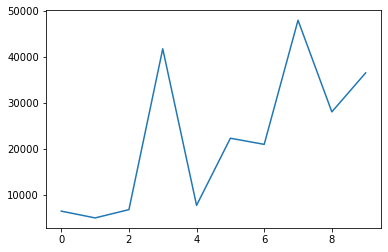

In [170]:
plt.plot(range(len(losses)), losses)
plt.show()